In [1]:
import cb_tools
import nibabel as nib
import seaborn as sns
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats import anova

In [2]:
run_firsttime = False
dataset = 'qMRI'
index = 'qMRI'
results_dir = '/nfs/s2/userhome/liuxbingyu/workingdir/cerebellum_grad_dev_v2'
save_fig_path = './figure'
subwise_parcellation_dir = os.path.join(results_dir, 'cb_parcellation_subwise/parcellation')
t1_dir = os.path.join(results_dir, 'jesse_data','qmri')
template = 'adult'  # ['adult', 'pediatric']

# pretrained template
template_para = {'pediatric': 'kki', 'adult': 'tmc'}

# sublist
sublist = os.listdir(os.path.join(subwise_parcellation_dir, dataset))

# atlas
atlas_cb_name = f'cb_acapulco_{template}'
atlas_dir = os.path.join(os.getcwd(), 'atlas')

In [14]:
#%%
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
dataset_dir = os.path.join(results_dir, index , dataset)
if os.path.exists(dataset_dir) is False: os.makedirs(dataset_dir)

save_path_roi = os.path.join(dataset_dir, f'{index}_{atlas_cb_name}_roi.npy')
save_path_roi_sublist = os.path.join(dataset_dir, f'{index}_{atlas_cb_name}_roi_sub')

In [4]:
#%% roi summary
if run_firsttime: 

    value_roi = []
    sub_valid = []
    for sub in sublist:

        # get voxel data
        data_sub_path = os.path.join(t1_dir, 'sub{0}_T1_map_Wlin.nii.gz'.format(sub))
        data_sub = nib.load(data_sub_path).get_fdata()

        # get atlas
        pcl_path = os.path.join(subwise_parcellation_dir, dataset, sub, template_para[template], f'sub{sub}_VIP_map_n4_mni_seg_post_inverse.nii.gz')

        if os.path.exists(pcl_path):
            atlas_data = nib.load(os.path.join(pcl_path)).get_fdata()
            atlas_cb = cb_tools.atlas_load(atlas_cb_name, atlas_dir, atlas_data=atlas_data)

            value_roi.append(cb_tools.roiing_volume(atlas_cb.data, data_sub, method='nanmedian', key=atlas_cb.label_info['key'])[1])

            sub_valid.append(sub)
            print(f'{sub} done')

    pd.DataFrame(sub_valid).to_csv(save_path_roi_sublist, index=False, header=False)

    # save
    value_roi = np.nan_to_num(np.asarray(value_roi))
    np.save(save_path_roi, value_roi)

    data_roi_df = pd.DataFrame(value_roi, columns=atlas_cb.label_info['name']).astype(np.float)
    data_roi_df.to_csv(os.path.join(results_dir, index, f'{index}_{atlas_cb_name}_voxel.csv'), index=0)


In [5]:
# %% roi results
data_roi_df = pd.read_csv(os.path.join(results_dir, index, f'{index}_{atlas_cb_name}_voxel.csv'))
atlas_cb = cb_tools.atlas_load(atlas_cb_name, atlas_dir)

def hemi_merging(x):
    # hemi
    x_l = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='l']]
    x_l.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)
    
    x_r = x[[x.columns[i] for i in range(x.shape[-1]) if x.columns[i].split('_')[-1]=='r']]   
    x_r.rename(columns=lambda x: f'{x.split("_")[0]}', inplace=True)

    other_col = [i for i in x.columns if i.split('_')[-1] not in ['l', 'r', 'Vermis']]
    x_merged = pd.concat([pd.concat([x_l,x_r]).mean(level=0), x[other_col]], axis=1)

    return x_merged

data_roi_df = hemi_merging(data_roi_df)
lobule_name = atlas_cb.label_info['lobule'][:11*2:2]

/nfs/s2/userhome/liuxingyu/.conda/envs/local/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


       F Value  Num DF  Den DF        Pr > F
roi  29.178934     3.0    45.0  1.244496e-10


<ipython-input-17-33693d4d6599>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sub'] = np.arange(1, len(data)+1, 1)


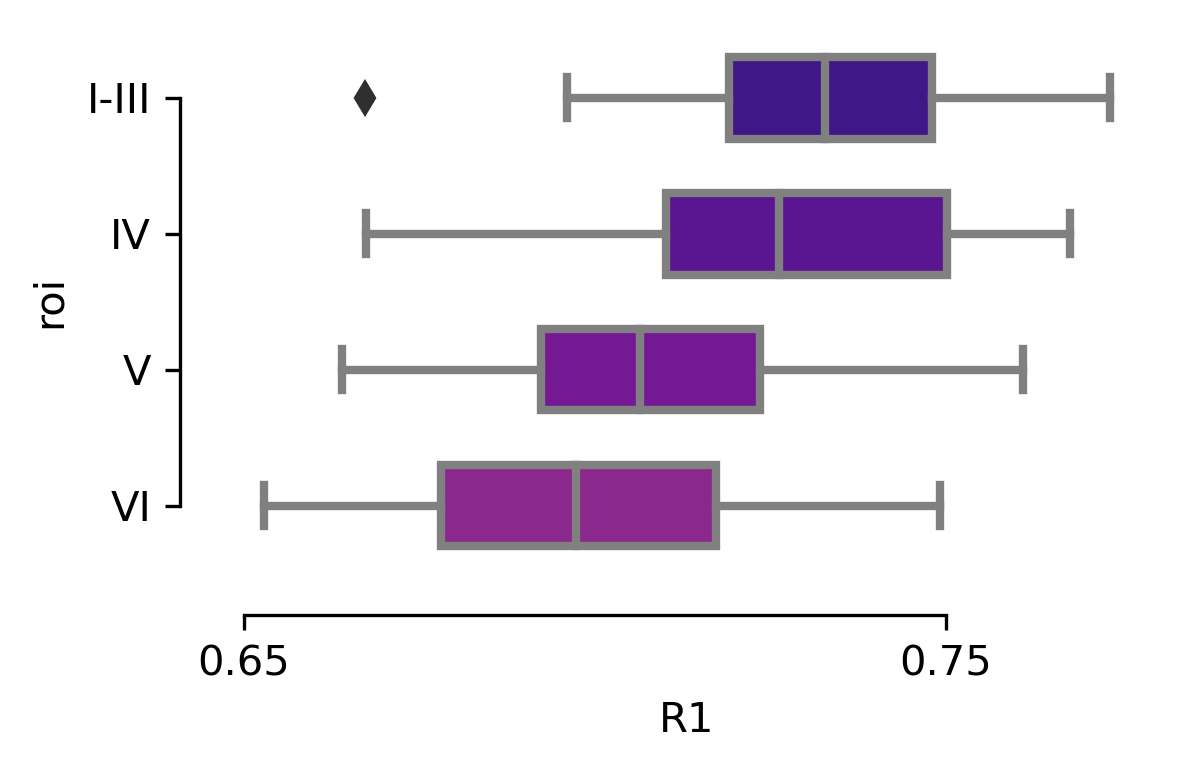

In [17]:
# %% plot
# data = data_roi_df
data = data_roi_df.iloc[:,:4]
data['Sub'] = np.arange(1, len(data)+1, 1)

# data stack
data_stack = pd.melt(data, value_vars=data.columns[:-1], id_vars=['Sub'],
                     var_name=['lobule'], value_name='T1')
data_stack['roi'] = data_stack['lobule']
data_stack['R1'] = 1 / data_stack['T1']

# plot
row = 'roi'
value = 'R1'
palette_cb = sns.color_palette('plasma', data_roi_df.shape[-1])

# box
fig, ax = plt.subplots(figsize=(4, 2.4))
sns.boxplot(x=value, y=row, palette=palette_cb, data=data_stack, ax=ax, \
    linewidth=2, width=0.6, boxprops={"edgecolor": "gray"}, whiskerprops={"color": "gray"}, medianprops={"color": "gray"}, capprops={"color": "gray"})
# sns.stripplot(x=value, y=row, data=data_stack, size=8, marker='o', linewidth=1, edgecolor='dimgray', color='lavenderblush', ax=ax)

ax.set_xticks((0.65, 0.75))
sns.despine(offset=10, trim=True, ax=ax)
plt.savefig(os.path.join(save_fig_path, f'{index}_{template}.pdf'), format='pdf', bbox_inches='tight', dpi=300)

# stats
# # stats
gradient_stats = anova.AnovaRM(data=data_stack, depvar=value, subject='Sub', within=['roi']).fit()
print(gradient_stats.anova_table)
